# **APTOS2019 Dataset**

# Imports

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import cv2
import tensorflow as tf
from tensorflow import keras

In [38]:
DATASET_PATH = '/content/drive/My Drive/University Of Stirling/Dissertation/retinal-rec/Datasets/APTOS2019'
TRAIN_PATH = DATASET_PATH + "/train_images/"
TEST_PATH = DATASET_PATH + "/test_images/"
TRAIN_PREP_PATH = DATASET_PATH + "/train_preprocessed/"
N_CLASSES = 5
IMG_SIZE = (512, 512)


In [39]:
from google.colab import drive
import os

drive.mount('/content/drive')

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

if not os.path.exists(TRAIN_PREP_PATH):
  os.mkdir(TRAIN_PREP_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CWD: /content/drive/My Drive/University Of Stirling/Dissertation/retinal-rec/Datasets/APTOS2019


## Display one image from each class

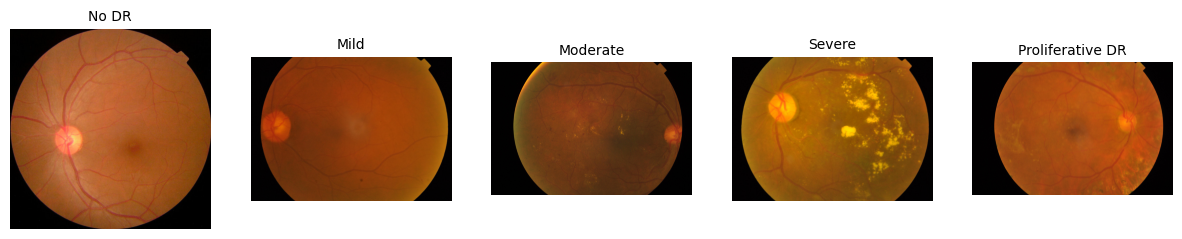

In [40]:
# Read labels
train = pd.read_csv(DATASET_PATH + "/train.csv")
test = pd.read_csv(DATASET_PATH + "/test.csv")

# Adjust figure sizes before display
plt.rcParams['figure.figsize'] = [15, 15] 
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['axes.titlesize'] = 10

# Instantiate plot
fig, ax = plt.subplots(1,5) 

classes = [ "No DR", "Mild", "Moderate", "Severe", "Proliferative DR" ]

for i in range(N_CLASSES):
  row = train.query("diagnosis ==" + str(i))
  img = cv2.imread(TRAIN_PATH + row["id_code"].values[0] + ".png")

  # cv2.COLOR_BGR2RGB is specified as CV2 utilises BGR, but our original image is RGB 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax[i].imshow(img) 
  ax[i].set_title(classes[i]) 
  ax[i].axis('off')
    

# Preprocessing

It is true that the background contrast has improved after histogram equalization. But compare the face of statue in both images. We lost most of the information there due to over-brightness. It is because its histogram is not confined to a particular region as we saw in previous cases (Try to plot histogram of input image, you will get more intuition).

So to solve this problem, adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied.

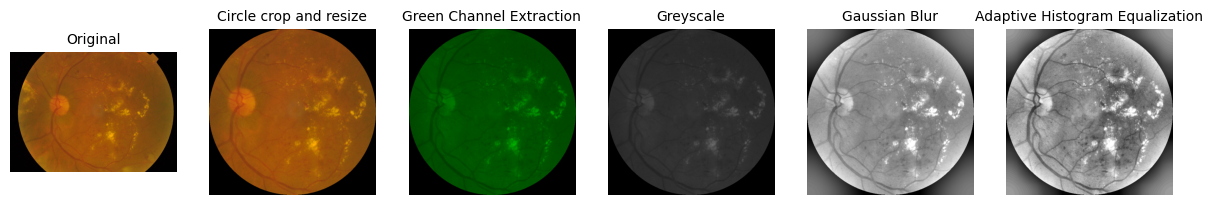

In [44]:
# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook
# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook
# ref for circle crop: https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img 

def preprocess(id_code):

  fig, ax = plt.subplots(1,6) 

  img = cv2.imread(TRAIN_PATH + id_code + ".png")

  ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[0].set_title("Original") 
  ax[0].axis('off')

  # Circle crop
  img = circle_crop(img)

  # Resize the image
  img = cv2.resize(img, IMG_SIZE)

  ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[1].set_title("Circle crop and resize") 
  ax[1].axis('off')

  # Extract Green Channel
  img[:,:,0] = 0
  img[:,:,2] = 0

  ax[2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[2].set_title("Green Channel Extraction") 
  ax[2].axis('off')

  # Convert to Greyscale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ax[3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[3].set_title("Greyscale") 
  ax[3].axis('off')

  # Apply Gaussian Blur
  img = cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , 512/10) ,-4 ,128)
  
  ax[4].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[4].set_title("Gaussian Blur") 
  ax[4].axis('off')

  # Perform histogram equalization

  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  img = clahe.apply(img)

  ax[5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[5].set_title("Adaptive Histogram Equalization") 
  ax[5].axis('off')

  #cv2.imwrite(TRAIN_PREP_PATH + id_code + ".png", img)


preprocess("0dc8d25b3f69") # Level 3

#for id_code in train["id_code"]:
 # preprocess(id_code) 

# **MESSIDOR Dataset**

Note: there is an available annotated csv for the MESSIDOR-2 dataset which includes DR grading 0-5 (https://www.kaggle.com/datasets/google-brain/messidor2-dr-grades) 

In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import cv2
import tensorflow as tf
from tensorflow import keras

In [46]:
DATASET_PATH = '/content/drive/My Drive/University Of Stirling/Dissertation/retinal-rec/Datasets/MESSIDOR'
TRAIN_PATH = DATASET_PATH + "/images/"
TRAIN_PREP_PATH = DATASET_PATH + "/images_preprocessed/"
N_CLASSES = 4
IMG_SIZE = (512, 512)

In [47]:
from google.colab import drive
import os

drive.mount('/content/drive')

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

if not os.path.exists(TRAIN_PREP_PATH):
  os.mkdir(TRAIN_PREP_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CWD: /content/drive/My Drive/University Of Stirling/Dissertation/retinal-rec/Datasets/MESSIDOR


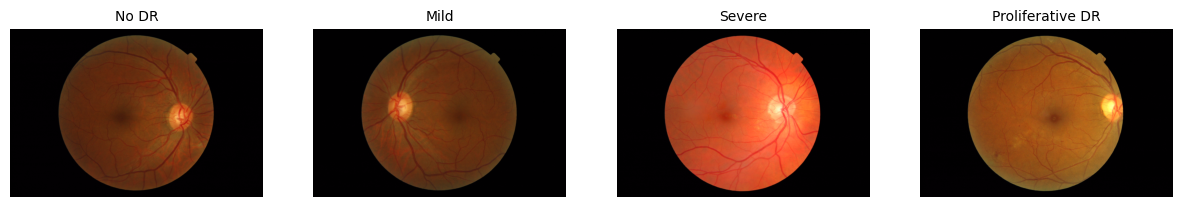

In [48]:
# Read labels
train = pd.read_excel(DATASET_PATH + '/diagnosis.xlsx') 

# Adjust figure sizes before display
plt.rcParams['figure.figsize'] = [15, 15] 
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['axes.titlesize'] = 10

# Instantiate plot
fig, ax = plt.subplots(1,N_CLASSES) 

classes = [ "No DR", "Mild", "Severe", "Proliferative DR" ]

for i in range(N_CLASSES):
  row = train.query("`Retinopathy grade` ==" + str(i))
  img = cv2.imread(TRAIN_PATH + row["Image name"].values[0])

  #cv2.COLOR_BGR2RGB is specified as CV2 utilises BGR, but our original image is RGB 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax[i].imshow(img) 
  ax[i].set_title(classes[i]) 
  ax[i].axis('off')

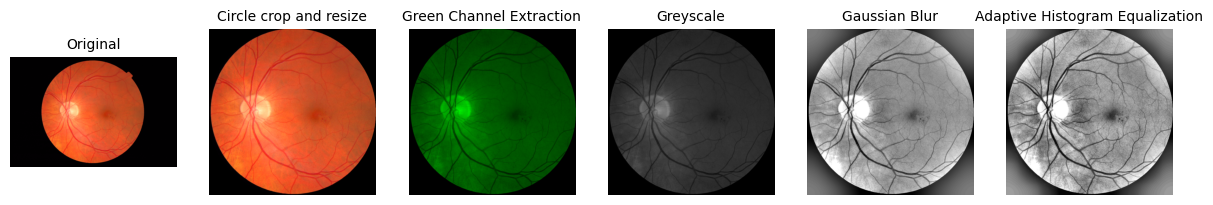

In [49]:
# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook
# ref for circle crop: https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img 

def preprocess(image_name):

  fig, ax = plt.subplots(1,6) 

  img = cv2.imread(TRAIN_PATH + image_name)

  ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[0].set_title("Original") 
  ax[0].axis('off')

  # Circle crop
  img = circle_crop(img)

  # Resize the image
  img = cv2.resize(img, IMG_SIZE)

  ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[1].set_title("Circle crop and resize") 
  ax[1].axis('off')

  # Extract Green Channel
  img[:,:,0] = 0
  img[:,:,2] = 0

  ax[2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[2].set_title("Green Channel Extraction") 
  ax[2].axis('off')

  # Convert to Greyscale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ax[3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[3].set_title("Greyscale") 
  ax[3].axis('off')

  # Apply Gaussian Blur
  img = cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , 512/10) ,-4 ,128)
  
  ax[4].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[4].set_title("Gaussian Blur") 
  ax[4].axis('off')

  # Perform histogram equalization

  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
  img = clahe.apply(img)

  ax[5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  ax[5].set_title("Adaptive Histogram Equalization") 
  ax[5].axis('off')

  #cv2.imwrite(TRAIN_PREP_PATH + image_name, img)


preprocess("20051020_43906_0100_PP.tif") # Level 3

#for id_code in train["id_code"]:
 # preprocess(id_code) 